# Detection with an Maximally Stable Extremal Region method

We decide to test the method on one image. The idea is to strat from MSER and then to add bias on shape and area.

In [2]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

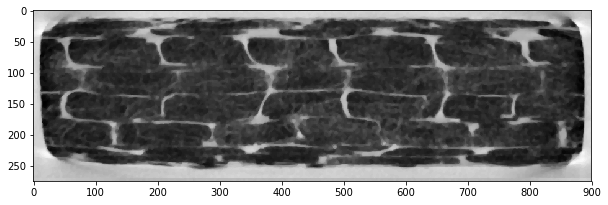

In [116]:
#Image importation

volume_source = imread("Denoised_Equalized_Volume.tif")

from skimage import img_as_float
volume_source = img_as_float(volume_source)
img_source = 1-volume_source[volume_source.shape[0]//2, :, :]
img_source = img_source
plt.figure(figsize=(10, 10))
plt.imshow(img_source, cmap=plt.get_cmap('gray'))

## MSER

MSER consist in applying multiple tresholds to the image for blob detection.
For each treshold, we consider the connected components are candidates blob. In the classic MSER, we look at the variation of the area of the blobs over the area between the tresholds, and we consider that we have a MSER at a local minimum.

### Tresholding

In [117]:
def image_tresholding(img, treshold = 0.5):
    res = img_as_float(img>treshold)
    return res

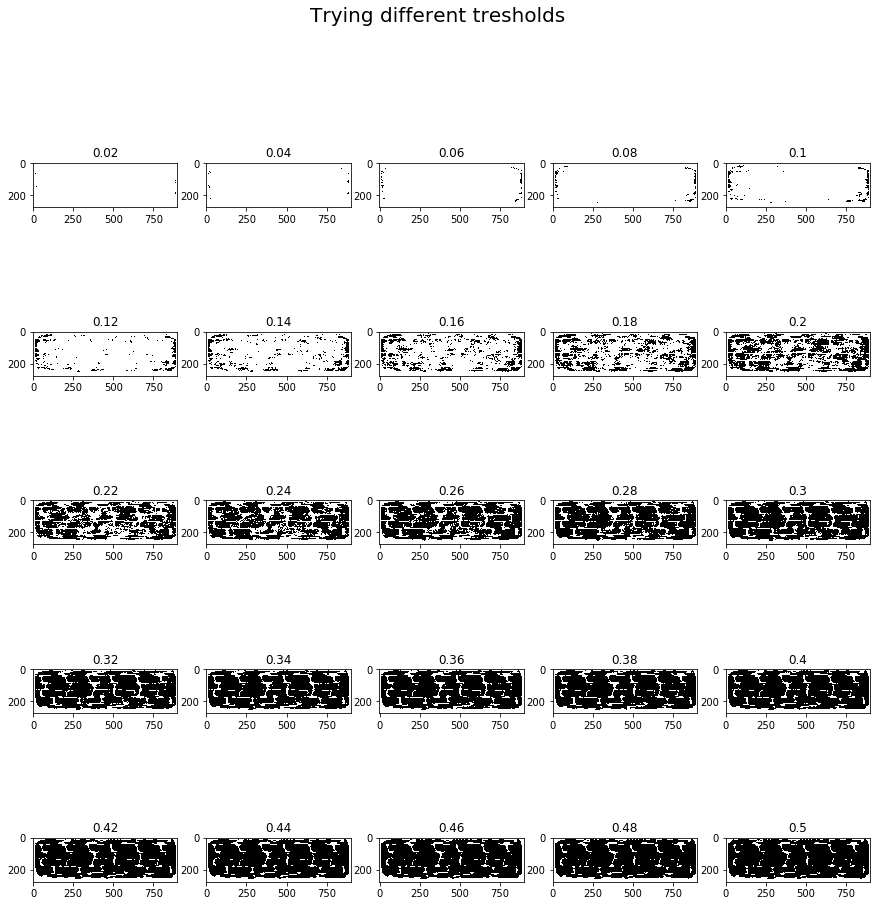

In [118]:
plt.figure(figsize=(15,15))
plt.suptitle("Trying different tresholds", fontsize=20)
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.title(0.02*i)
    plt.imshow(image_tresholding(img_source, 0.02*i), cmap='gray')

### Connected conponents

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
146


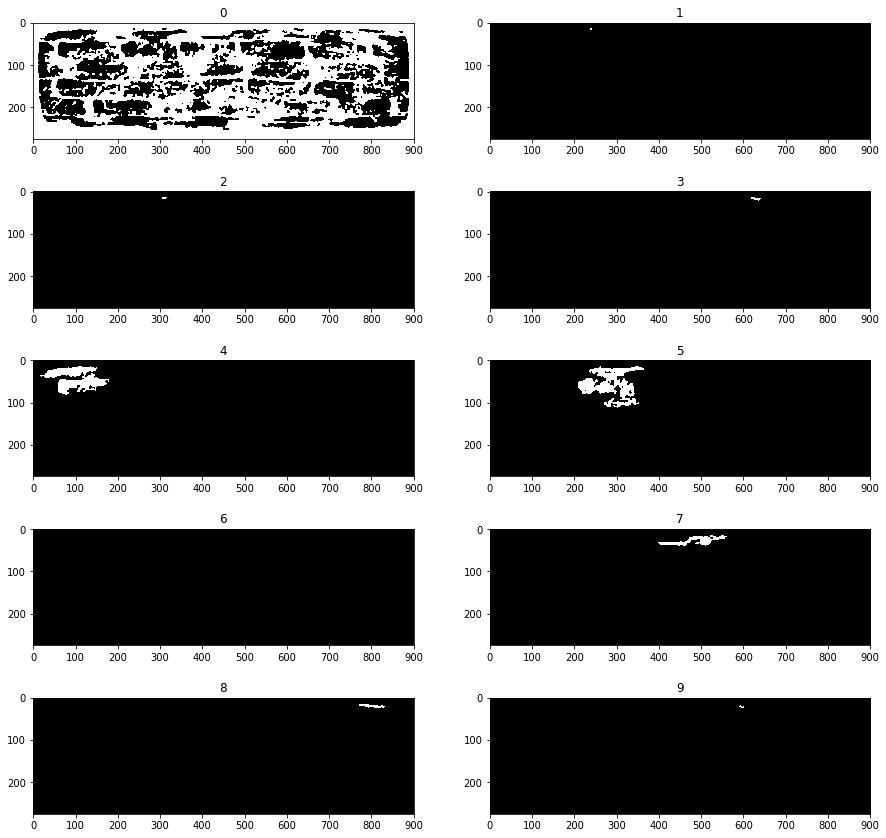

In [119]:
#return the connex component of a black pixel( the 0s), with 8 connectivity
connectivity = 8
tresh = 0.2

#test
from skimage import img_as_ubyte
test_img = img_as_ubyte(1-image_tresholding(img_source, tresh))
label_num, labels = cv2.connectedComponents(test_img)
print(test_img)
print(label_num)
#10 labels, the 0 is the background
plt.figure(figsize=(15,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    plt.title(i-1)
    plt.imshow(labels == (i-1), cmap='gray')

Let's look at how the number of components evolve.

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


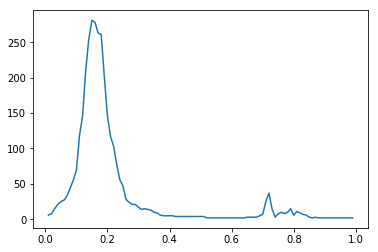

In [120]:
tresholds = []
number_compo = []
for i in range(1, 100):
    tresholds.append(i*0.01)
    test_img = img_as_ubyte(1-image_tresholding(img_source, i*0.01))
    label_num, labels = cv2.connectedComponents(test_img)
    number_compo.append(label_num)
plt.plot(tresholds, number_compo)

For a low treschold (before 0.2), it increases as new potential fibers are detected, and after this pic, it decreases as they are mainly merged, it is in this part that we will have to add bias on different parameters (like shape or area).  
After 0.5, the number of components tend to remain stable.

### Area evolution between 2 tresholds

We first only look at how the area of the components evolve betwee 2 tresholds.

If between 2 tresholds, different components are linked, we look at the overall area evolution, considering that they were in the same component, therefore we first have to link the conponents in the smaller and greater treshold, we create a matrix for that (leaving alone the background, label 0). Each row is a conponent of the higher tresholds, and each column is a label for the lower treshold. The element i,j is 0 if the 2 conponent are linked, 0 else.

In [121]:
def compo_linking(n1, labels1, n2, labels2):
    res = np.zeros((n2, n1))
    row, col = labels2.shape
    for i in range(row):
        for j in range(col):
            res[labels2[i][j]][labels1[i][j]] = 1
    return res
#the row and col 0 are the background

In [122]:
#test 0.30 and 0.35

connectivity = 8
tresh1 = 0.3
tresh2 = 0.35

test_img1 = img_as_ubyte(1-image_tresholding(img_source, tresh1))
test_img2 = img_as_ubyte(1-image_tresholding(img_source, tresh2))
label_num1, labels1 = cv2.connectedComponents(test_img1)
label_num2, labels2 = cv2.connectedComponents(test_img2)
label_link = compo_linking(label_num1, labels1, label_num2, labels2)
label_link

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.]])

The first column correspond to the background, the expanding of the zones from the background pixels.

In [123]:
def area_growth_rate(n2, labels1, labels2, label_link, former_rate1 = []):
    rate = []
    former_rate2 = []
    if len(former_rate1) == 0:
        former_rate1 = np.zeros(label_link.shape[1])
    for compo2 in range(n2):
        area2 = sum(sum(labels2 == compo2))
        area1 = 0
        former_rate2.append(None)
        for i in range(1, label_link.shape[1]):
            if label_link[compo2][i]:
                area1 += sum(sum(labels1 == i))
                if not(former_rate1[i] is None):
                    if former_rate2[compo2] is None:
                        former_rate2[compo2] = 0
                    former_rate2[compo2] += sum(sum(labels1 == i)) * former_rate1[i]
        if (area1 == 0):
            rate.append(None)
            former_rate2[compo2] = None
        else:
            if not(former_rate2[compo2] is None):
                former_rate2[compo2] = former_rate2[compo2]/area1
            else:
                former_rate2[compo2] = None
            if (area2 != 0):
                rate.append((area2-area1)/area2)
            else:
                rate.append(None)
    return rate, former_rate2

In [10]:
#test
area_growth_rate(label_num2, labels1, labels2, label_link)

([None,
  0.059143022514806215,
  0.7391304347826086,
  0.2074468085106383,
  None,
  0.21739130434782608,
  0.24096385542168675,
  None,
  None,
  0.4339622641509434],
 [None, 0.0, 0.0, 0.0, None, 0.0, 0.0, None, None, 0.0])

### MSER with area growth rate

Having all the individual parts of the algorithm, we implement the algorithm here.  
We decide to go with tresholds from 0.05 to 0.6 with steps of 0.05.  
We stop to grow the areas at the minimum of the growth rates.   
When an area stopped growing, we "artificially create a border around it, before looking for connected conponents.

In [126]:
def add_compo(compo, labels, tresh_img):
    #We add the convex envelop by row
    #for each row, we look for the max and min colum of the component, fill the interrior with 255 and add 0 outside
    res = tresh_img
    row, col = labels.shape
    compo_img = (labels == compo)
    compo_img = img_as_ubyte(compo_img)
    first_row = False
    fill_first_row = False
    former_min_col = res.shape[1]
    former_max_col = 0
    for i in range(row):
        min_col = 0
        max_col = 0
        first_col = False
        for j in range(col):
            if compo_img[i][j] == 255:
                if first_row == False:
                    first_row = True
                    fill_first_row = True
                if first_col == False:
                    min_col = j
                    first_col = True
                max_col = j
        res[i][min_col:max_col] = 255
        if fill_first_row:
            fill_first_row = False
            if i>0:
                res[i-1][min_col:max_col] = 0
                if min_col > 0:
                    res[i-1][min_col-1] = 0
                if max_col < (col-1):
                    res[i-1][max_col+1] = 0
        if i>0:
            if min_col <= former_min_col:
                res[i-1][(min_col-1):(former_min_col+1)] = 0
            if max_col >= former_max_col:
                res[i-1][(former_max_col-1):(max_col+1)] = 0
        if min_col > 0:
            res[i][min_col-1] = 0
        if max_col < (col-1):
            res[i][max_col+1] = 0
        if i<(row-1):
            res[i+1][min_col:max_col] = 0
            if min_col > 0:
                res[i+1][min_col-1] = 0
            if max_col < (col-1):
                res[i+1][max_col+1] = 0
        former_min_col = min_col
        former_max_col = max_col
    return res

def MSER_area_growth(img_source, min_tresh, max_tresh, tresh_step):
    #initialisation
    tresh = min_tresh
    tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
    label_num1, labels1 = cv2.connectedComponents(tresh_image)
    growth_rate1 = []
    stopped_compo1 = []
    it = 0
    if label_num1 > 0:
        for i in range(0, label_num1):
            growth_rate1.append(None)
            stopped_compo1.append(False)
    while tresh <= max_tresh:
        #iterations
        it+=1
        print(it)
        #tresholding
        tresh = tresh + tresh_step
        tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
        #add the fixed components to the tresholding
        if label_num1 > 0:
            for i in range(1, label_num1):
                if stopped_compo1[i]:
                    tresh_image = add_compo(i, labels1, tresh_image)
        #We find the connected components and link them
        label_num2, labels2 = cv2.connectedComponents(tresh_image)
        label_link = compo_linking(label_num1, labels1, label_num2, labels2)
        #We calculate the growth rate
        growth_rate2, former_rate = area_growth_rate(label_num2, labels1, labels2, label_link, growth_rate1)
        #if it == 1:
            #print(growth_rate1)
            #print(former_rate)
        #We stop the growth if the component was stopped before or if the growth rate is lower
        stopped_compo2 = []
        for compo2 in range(label_num2):
            stopped = False
            for i in range(1, label_num1):
                if (label_link[compo2][i]) and (stopped_compo1[i]):
                    stopped = True
            if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] > former_rate[compo2]:
                stopped = True
            #if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] < 0.1:
            #    stopped = True
            stopped_compo2.append(stopped)
            
        #We actualize the variables
        label_num1 = label_num2
        print(label_num1)
        labels1 = labels2
        growth_rate1 = growth_rate2
        stopped_compo1 = stopped_compo2
        print(sum(stopped_compo1))
    return label_num1, labels1, stopped_compo1

In [12]:
n, labels, stopped = MSER_area_growth(img_source, min_tresh = 0.05, max_tresh = 0.5, tresh_step = 0.05)
n

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1
69
0
2
281
3
3
165
13
4
192
15
5
205
20
6
203
34
7
247
50
8
300
75
9
339
145
10
409
177


409

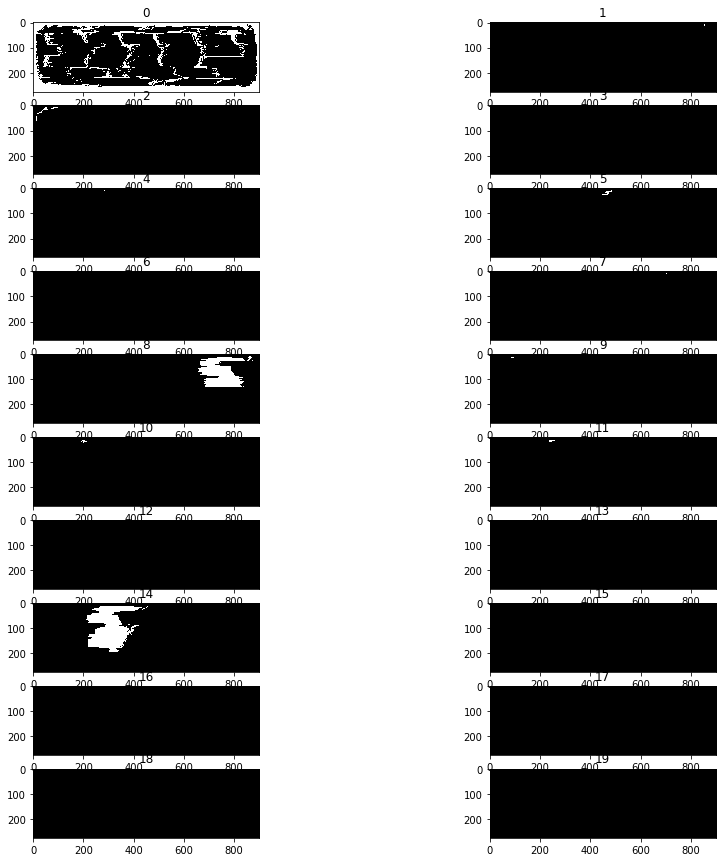

In [13]:
#10 labels, the 0 is the background
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(10,2,i)
    plt.title(i-1)
    plt.imshow(labels == (i-1), cmap='gray')

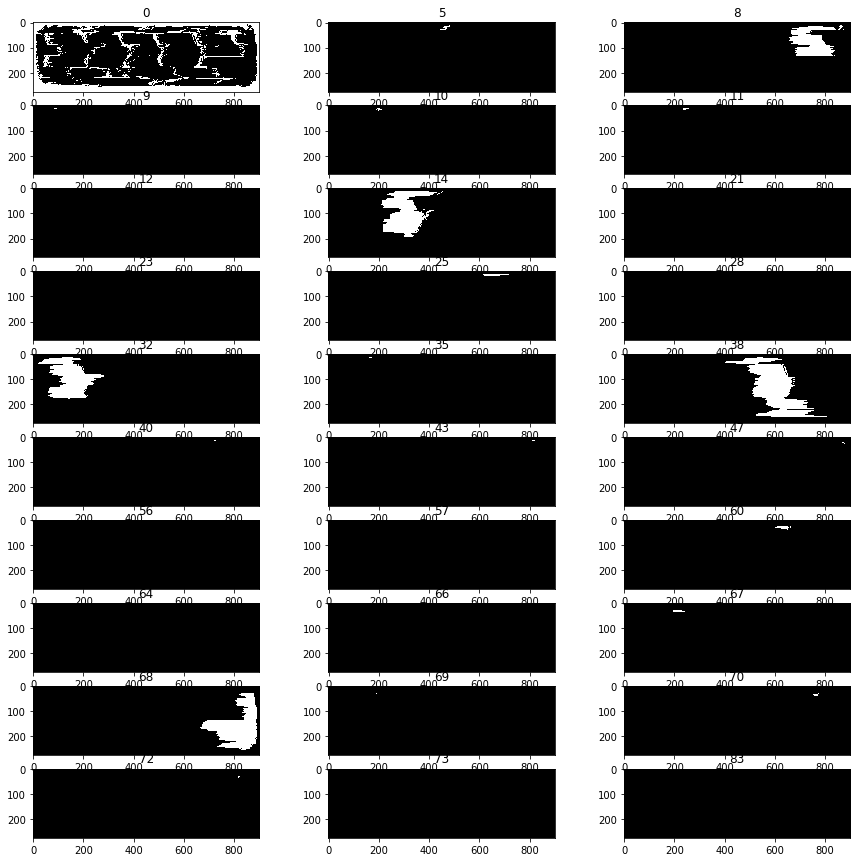

In [14]:
#the stopped component
plt.figure(figsize=(15,15))
i = 0
index = 0
while i<30:
    if stopped[(index-1)]:
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

## Area filtering
We decide to filter according to filter accdoing to the surface area

In [100]:
def compo_surface(compo, labels):
    res = sum(sum(labels == compo))
    return res

In [ ]:
#the stopped component
min_area = 5000
plt.figure(figsize=(15,15))
i = 0
index = 0
while i<30:
    if index>n:
        break
    if (stopped[(index-1)]) and (compo_surface(index-1, labels)>=min_area):
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

In [17]:
#test for add a component
"""
plt.imshow(add_compo(1, labels1, test_img2), cmap=plt.get_cmap('gray'))

label_num, labels = cv2.connectedComponents(add_compo(1, labels1, test_img2))
print(test_img)
print(label_num)
#10 labels, the 0 is the background
plt.figure(figsize=(15,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    plt.title(i-1)
    plt.imshow(labels == (i-1), cmap='gray')
"""

"\nplt.imshow(add_compo(1, labels1, test_img2), cmap=plt.get_cmap('gray'))\n\nlabel_num, labels = cv2.connectedComponents(add_compo(1, labels1, test_img2))\nprint(test_img)\nprint(label_num)\n#10 labels, the 0 is the background\nplt.figure(figsize=(15,15))\nfor i in range(1,11):\n    plt.subplot(5,2,i)\n    plt.title(i-1)\n    plt.imshow(labels == (i-1), cmap='gray')\n"

## Amelioration
For the stopped components, we merge them with the background if their area is smaller than min_area.

In [124]:
def remove_compo(compo, labels, img):
    row, col = labels.shape
    res = img
    for i in range(row):
        for j in range(col):
            if (labels[i,j] == compo):
                res[i,j] = 255
    return res

def MSER_area_growth_2(img_source, min_tresh, max_tresh, tresh_step, min_area):
    #initialisation
    tresh = min_tresh
    tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
    label_num1, labels1 = cv2.connectedComponents(tresh_image)
    growth_rate1 = []
    stopped_compo1 = []
    #background__to_add = np.zeros(img_source.shape)
    it = 0
    row, col = img_source.shape
    background = np.zeros(img_source.shape)
    if label_num1 > 0:
        for i in range(0, label_num1):
            growth_rate1.append(None)
            stopped_compo1.append(False)
    while tresh <= max_tresh:
        #iterations
        it+=1
        print(it)
        #tresholding
        tresh = tresh + tresh_step
        tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
        #add the fixed components to the tresholding
        if label_num1 > 0:
            for i in range(1, label_num1):
                if stopped_compo1[i]:
                    if compo_surface(i, labels1) < min_area:
                        background = remove_compo(i, labels1, background)
                    else:
                        tresh_image = add_compo(i, labels1, tresh_image)
        for i in range(row):
            for j in range(col):
                if background[i, j]:
                    tresh_image[i,j] = 0.
        #We find the connected components and link them
        label_num2, labels2 = cv2.connectedComponents(tresh_image)
        label_link = compo_linking(label_num1, labels1, label_num2, labels2)
        #We calculate the growth rate
        growth_rate2, former_rate = area_growth_rate(label_num2, labels1, labels2, label_link, growth_rate1)
        #if it == 1:
            #print(growth_rate1)
            #print(former_rate)
        #We stop the growth if the component was stopped before or if the growth rate is lower
        stopped_compo2 = []
        for compo2 in range(label_num2):
            stopped = False
            for i in range(1, label_num1):
                if (label_link[compo2][i]) and (stopped_compo1[i]):
                    stopped = True
            if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] > former_rate[compo2]:
                stopped = True
            #if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] < 0.1:
            #    stopped = True
            stopped_compo2.append(stopped)
            
        #We actualize the variables
        label_num1 = label_num2
        print(label_num1)
        labels1 = labels2
        growth_rate1 = growth_rate2
        stopped_compo1 = stopped_compo2
        print(sum(stopped_compo1))
    return label_num1, labels1, stopped_compo1, background

In [127]:
n, labels, stopped, background = MSER_area_growth_2(img_source, min_tresh = 0.05, max_tresh = 0.5, tresh_step = 0.05, min_area = 1000)
n

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1
69
0
2
281
3
3
161
11
4
164
11
5
164
14
6
194
17
7
235
26
8
263
20
9
224
36
10
285
26


285

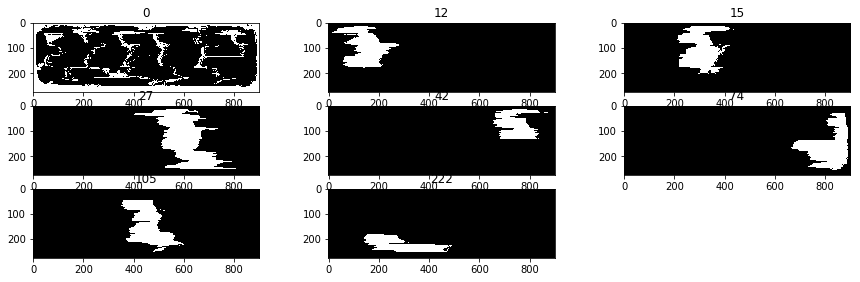

In [128]:
#the stopped component
min_area = 1000
plt.figure(figsize=(15,15))
i = 0
index = 0
while i<30:
    if index>n:
        break
    if (stopped[(index-1)]) and (compo_surface(index-1, labels)>=min_area):
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

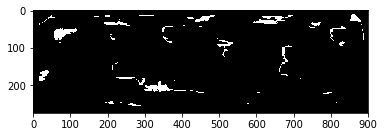

In [129]:
plt.imshow(background, cmap='gray')

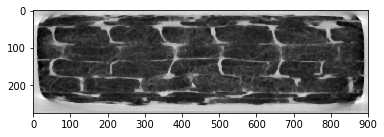

In [130]:
plt.imshow(img_source, cmap=plt.get_cmap('gray'))

13809

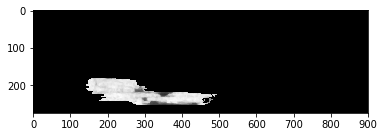

In [131]:
test_img = np.zeros(img_source.shape)
row, col = img_source.shape
for i in range(row):
    for j in range(col):
        if labels[i][j] == 222:
            test_img[i][j] = 1-img_source[i][j]
plt.imshow(test_img, cmap=plt.get_cmap('gray'))
compo_surface(222, labels)

## Penalizing the growth_rate with an area

In [68]:
def area_growth_rate_p(n2, labels1, labels2, label_link, former_rate1 = [], target_area = 5000, pen = 1):
    rate = []
    former_rate2 = []
    if len(former_rate1) == 0:
        former_rate1 = np.zeros(label_link.shape[1])
    for compo2 in range(n2):
        area2 = sum(sum(labels2 == compo2))
        area1 = 0
        former_rate2.append(None)
        for i in range(1, label_link.shape[1]):
            if label_link[compo2][i]:
                area1 += sum(sum(labels1 == i))
                if not(former_rate1[i] is None):
                    if former_rate2[compo2] is None:
                        former_rate2[compo2] = 0
                    former_rate2[compo2] += sum(sum(labels1 == i)) * former_rate1[i]
        if (area1 == 0):
            rate.append(None)
            former_rate2[compo2] = None
        else:
            if not(former_rate2[compo2] is None):
                former_rate2[compo2] = former_rate2[compo2]/area1 + pen*(area1-target_area)**2
            else:
                former_rate2[compo2] = None
            if (area2 != 0):
                rate.append(((area2-area1)/area2) + pen*(area2-target_area)**2)
            else:
                rate.append(None)
    return rate, former_rate2

In [69]:
def MSER_pen_area_growth(img_source, min_tresh, max_tresh, tresh_step, min_area, target_area, pen_area):
    #initialisation
    tresh = min_tresh
    tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
    label_num1, labels1 = cv2.connectedComponents(tresh_image)
    growth_rate1 = []
    stopped_compo1 = []
    #background__to_add = np.zeros(img_source.shape)
    it = 0
    row, col = img_source.shape
    background = np.zeros(img_source.shape)
    if label_num1 > 0:
        for i in range(0, label_num1):
            growth_rate1.append(None)
            stopped_compo1.append(False)
    while tresh <= max_tresh:
        #iterations
        it+=1
        print(it)
        #tresholding
        tresh = tresh + tresh_step
        tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
        #add the fixed components to the tresholding
        if label_num1 > 0:
            for i in range(1, label_num1):
                if stopped_compo1[i]:
                    if compo_surface(i, labels1) < min_area:
                        background = remove_compo(i, labels1, background)
                    else:
                        tresh_image = add_compo(i, labels1, tresh_image)
        for i in range(row):
            for j in range(col):
                if background[i, j]:
                    tresh_image[i,j] = 0.
        #We find the connected components and link them
        label_num2, labels2 = cv2.connectedComponents(tresh_image)
        label_link = compo_linking(label_num1, labels1, label_num2, labels2)
        #We calculate the growth rate
        growth_rate2, former_rate = area_growth_rate_p(label_num2, labels1, labels2, label_link, growth_rate1, target_area, pen_area)
        #if it == 1:
            #print(growth_rate1)
            #print(former_rate)
        #We stop the growth if the component was stopped before or if the growth rate is lower
        stopped_compo2 = []
        for compo2 in range(label_num2):
            stopped = False
            for i in range(1, label_num1):
                if (label_link[compo2][i]) and (stopped_compo1[i]):
                    stopped = True
            if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] > former_rate[compo2]:
                stopped = True
            #if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] < 0.1:
            #    stopped = True
            stopped_compo2.append(stopped)
            
        #We actualize the variables
        label_num1 = label_num2
        print(label_num1)
        labels1 = labels2
        growth_rate1 = growth_rate2
        stopped_compo1 = stopped_compo2
        print(sum(stopped_compo1))
    return label_num1, labels1, stopped_compo1, background

In [93]:
n, labels, stopped, background = MSER_pen_area_growth(img_source, min_tresh = 0.05, max_tresh = 0.5, tresh_step = 0.05, min_area = 1000, target_area = 3000, pen_area = 1)
n

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1
69
0
2
281
0
3
146
6
4
142
11
5
200
10
6
185
10
7
180
11
8
197
16
9
204
18
10
183
14


183

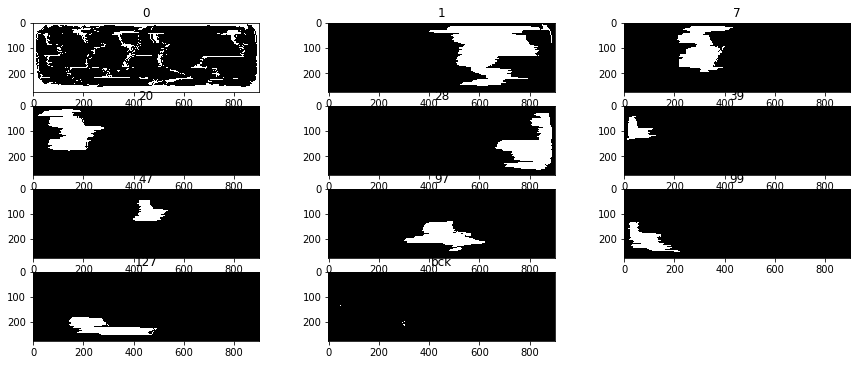

In [94]:
#the stopped component
min_area = 5000
plt.figure(figsize=(15,15))
i = 0
index = 0
while i<30:
    if index>n:
        i+=1
        plt.subplot(10,3,i)
        plt.title("bck")
        plt.imshow(background, cmap='gray')
        break
    if (stopped[(index-1)]) and (compo_surface(index-1, labels)>=min_area):
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

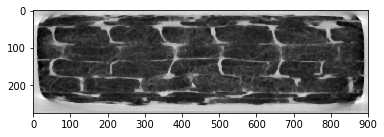

In [95]:
plt.imshow(img_source, cmap=plt.get_cmap('gray'))

In [108]:
import cv2
from skimage import img_as_ubyte
vis = img_as_ubyte(img_source).copy()
mser = cv2.MSER_create( _delta = 1, _max_area = 10000, _max_variation = 0.01)
regions, _ = mser.detectRegions((255-img_as_ubyte(img_source)))
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
#cv2.imshow('img', vis)

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


array([[203, 203, 203, ..., 193, 190, 190],
       [203, 203, 203, ...,   0,   0, 190],
       [203, 203, 203, ..., 193,   0, 190],
       ...,
       [198, 198, 199, ..., 203,   0, 203],
       [198, 198, 198, ...,   0,   0, 203],
       [198, 198, 198, ..., 203, 203, 203]], dtype=uint8)

In [83]:
img_as_ubyte(img_source)

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


array([[203, 203, 203, ..., 193, 190, 190],
       [203, 203, 203, ..., 193, 190, 190],
       [203, 203, 203, ..., 193, 190, 190],
       ...,
       [198, 198, 199, ..., 203, 203, 203],
       [198, 198, 198, ..., 203, 203, 203],
       [198, 198, 198, ..., 203, 203, 203]], dtype=uint8)

In [97]:
labels = np.zeros(img_source.shape)
for i in range(len(regions)):
    for x,y in regions[i]:
        labels[y,x] = i

In [109]:
len(regions)

248

KeyboardInterrupt: 

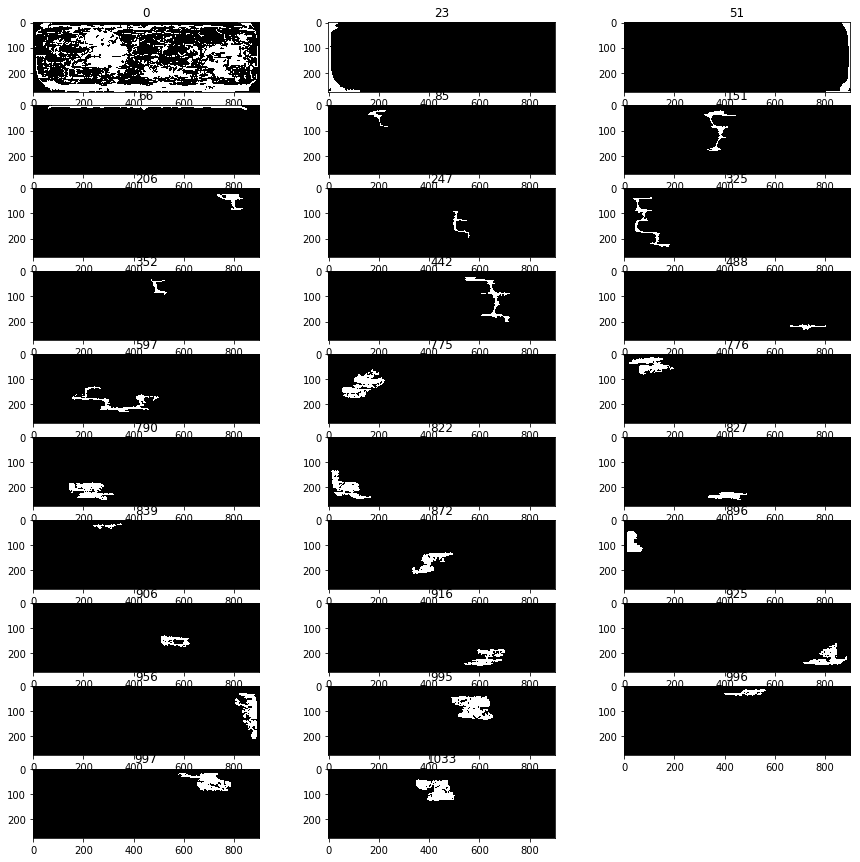

In [110]:
#the stopped component
plt.figure(figsize=(15,15))
min_area = 1000
i = 0
index = 0
while i<30:
    if (compo_surface(index-1, labels)>=min_area):
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


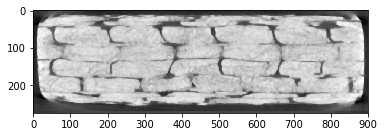

In [86]:
plt.imshow(255-img_as_ubyte(img_source), cmap=plt.get_cmap('gray'))